In this notebook we leverage the rotated resampled and aligned annotation volumes. 
We have to guess the anontations in each voxel though as they were changed to an INT between 0 and 3000 for visualisation purposes

In [1]:
import os
import SimpleITK as sitk
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
import nrrd
import pandas as pd
import cv2

In [2]:
version = '20231215'
download_base = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)

We open ABC annotation volumes, provided to support MERFISH slices

In [3]:
volumes = manifest['file_listing']['MERFISH-C57BL6J-638850-CCF']['image_volumes']

print("reading resampled_average_template")
rpath = volumes['resampled_average_template']['files']['nii.gz']['relative_path']
file = os.path.join( download_base, rpath)
average_template_image = sitk.ReadImage( file )
average_template_array = sitk.GetArrayViewFromImage( average_template_image )

print("reading resampled_annotation")
rpath = volumes['resampled_annotation']['files']['nii.gz']['relative_path']
file = os.path.join( download_base, rpath)
print(file)
annotation_image = sitk.ReadImage( file )
annotation_array = sitk.GetArrayViewFromImage( annotation_image )

print("reading resampled_annotation_boundary")
rpath = volumes['resampled_annotation_boundary']['files']['nii.gz']['relative_path']
file = os.path.join( download_base, rpath)
annotation_boundary_image = sitk.ReadImage( file )
annotation_boundary_array = sitk.GetArrayViewFromImage( annotation_boundary_image )


reading resampled_average_template
reading resampled_annotation
/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/image_volumes/MERFISH-C57BL6J-638850-CCF/20230630/resampled_annotation.nii.gz
reading resampled_annotation_boundary


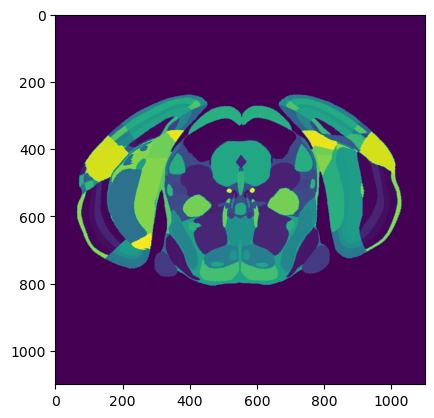

In [4]:
zindex = 21
plt.imshow(annotation_array[zindex, :, :]);

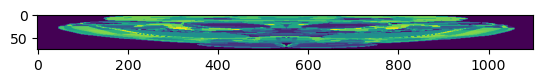

In [5]:
#You can see it only contains certain slices, many are missing in-between:
plt.imshow(annotation_array[ :, 500, :]);

The annotation values were changed for better visualisation: fake ids. These ids are stored by Allen, this is an alternative way to calculate them. 

In [6]:
volumes = manifest['file_listing']['Allen-CCF-2020']['image_volumes']

print("reading annotation_10")
rpath = volumes['annotation_10']['files']['nii.gz']['relative_path']
file = os.path.join( download_base, rpath)
print(file)
annotation_image_f = sitk.ReadImage( file )
annotation_array_f = sitk.GetArrayViewFromImage( annotation_image_f )
annotation_array_f = np.transpose(annotation_array_f).astype(np.uint16)

reading annotation_10
/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/image_volumes/Allen-CCF-2020/20230630/annotation_10.nii.gz


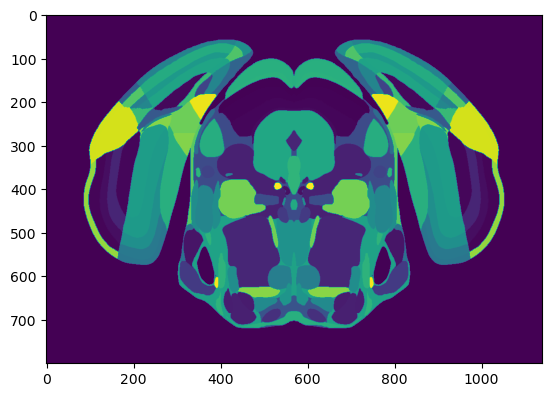

In [7]:
plt.imshow(annotation_array_f[966, :, :]);

While the slicing angle difference gives different regions apparent in the slice we can still match all region values with region ids..

In [8]:
#Let's open a real annotation volume
avol, _ = nrrd.read('/gpfs/bbp.cscs.ch/home/veraszto/bbp_prod_files/2022/annotation_10.nrrd')

### REMOVE 0s around brain boundary

array.shape is larger than necessary (probably this extra space was there for alignment)

In [9]:

arr_flat = avol.flatten()

dict1 = {}
# Use np.unique to get unique elements and their counts
unique_elements, counts = np.unique(arr_flat, return_counts=True)

# Combine unique elements and their counts into a dictionary
dict1 = dict(zip(unique_elements, counts))


In [10]:
arr_flat = annotation_array_f.flatten()
#arr_flat = annotation_array.flatten() #We should not use the morphed array because it has less regions.

dict2 = {}
# Use np.unique to get unique elements and their counts
unique_elements, counts = np.unique(arr_flat, return_counts=True)

# Combine unique elements and their counts into a dictionary
dict2 = dict(zip(unique_elements, counts))

In [11]:
len(dict1) == len(dict2)

True

Test if there are duplicates: this means two regions have the same number of voxels, so we have to figure out which one is which

In [12]:
from collections import Counter

# Count occurrences of each value in dict1
value_counts = Counter(dict1.values())

# Find duplicates (values with counts greater than 1)
duplicates = {value: count for value, count in value_counts.items() if count > 1}
duplicates

{2: 2, 37530: 2}

In [13]:
# Count occurrences of each value in dict1
value_counts = Counter(dict1.values())

# Find duplicates (values with counts greater than 1)
duplicates = {value: count for value, count in value_counts.items() if count > 1}

# Iterate through dict1 and modify one of the duplicate values by appending 'a'
for key, value in dict1.items():
    if value in duplicates:
        dict1[key] = value if duplicates[value] == 1 else f"{value}a"
        duplicates[value] -= 1

value_counts = Counter(dict2.values())

# Find duplicates (values with counts greater than 1)
duplicates = {value: count for value, count in value_counts.items() if count > 1}

# Iterate through dict2 and modify one of the duplicate values by appending 'a'
for key, value in dict2.items():
    if value in duplicates:
        dict2[key] = value if duplicates[value] == 1 else f"{value}a"
        duplicates[value] -= 1

Test if there is a missing region id

In [14]:
# Swap keys and values using dictionary comprehension
dict1_swapped = {value: key for key, value in dict1.items()}
dict2_swapped = {value: key for key, value in dict2.items()}


# Loop through the keys of dict1
for key1 in dict1_swapped:
    # Get the corresponding value from dict2
    value2 = dict2_swapped.get(key1)
    # Check if the value from dict1 matches the value from dict2
    if value2 is None:
        print(f"Value mismatch for key '{key1}': {dict1_swapped[key1]} (dict1) vs {value2} (dict2)")


In [15]:
# Get the unique elements from dict1.keys()
keys_unique = set(dict1.keys())

# Get the unique elements from dict1_swapped.values()
values_unique = set(dict1_swapped.values())

# Find the unique elements between the two sets
unique_elements = keys_unique.symmetric_difference(values_unique)

print("Unique elements:", unique_elements)


Unique elements: set()


In [16]:
dict1_swapped.keys() == dict2_swapped.keys()

True

In [17]:
len(dict1_swapped.keys()), len(dict2_swapped.keys())

(688, 688)

In [18]:
# Create DataFrame
df = pd.DataFrame({'Region_id': list(dict1_swapped.values()), 
                   'Fake_Region_id': list(dict2_swapped.values())},
                  index=dict1_swapped.keys())

#df index is the full voxel count for the regions and still contains duplicates in the index

We addressed the duplicates, ie regions with the same volume, with dict_swapped

In [19]:
# Group the DataFrame by the 'Fake_Region_id' column
grouped = df.groupby('Region_id')

# Find groups with more than one row
grouped.filter(lambda x: len(x) > 1)

,Region_id,Fake_Region_id


In [20]:
grouped =  df.groupby(level=0)

# Find groups with more than one row
grouped.filter(lambda x: len(x) > 1)


,Region_id,Fake_Region_id


In [21]:
df[df['Fake_Region_id'] == 747]

,Region_id,Fake_Region_id
37530,757,747


In [22]:
df[df.index == 37530]

,Region_id,Fake_Region_id
37530,757,747


In [23]:
type(df.index[0])

numpy.int64

Finally, remove the 'a' string from the duplicated indexes

In [24]:
# Iterate over the index and modify elements
for i, index_value in enumerate(df.index):
    if isinstance(index_value, str):  # Check if the element is a string
        # Remove non-numeric characters
        numeric_value = ''.join(filter(str.isdigit, index_value))
        # Change dtype to numpy.int64
        df.index.values[i] = np.int64(numeric_value)


In [25]:
#These were the duplicates ie region ids with the same volume
df[df.index == 37530], df[df.index == 2]

(       Region_id  Fake_Region_id
 37530        530             520
 37530        757             747,
    Region_id  Fake_Region_id
 2        463             453
 2        545             535)

# Calculate voxel counts for each slice

Now that we know which fake region id is which region id, we can check every slice and estimate the densities for every region

In [26]:
annotation_array.shape, annotation_array_f.shape #We never have to bother with the 0s around the brain, just keep the diff shape in mind

((76, 1100, 1100), (1320, 800, 1140))

In [27]:
arr_flat = annotation_array[0].flatten()

# Use np.unique to get unique elements and their counts
unique_elements, counts = np.unique(arr_flat, return_counts=True)

# Combine unique elements and their counts into a dictionary
fake_regid_counts = dict(zip(unique_elements, counts))

In [28]:
#This data comes from: np.sort(np.unique(cells['template_nr']))
template_nr = [4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 
               23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 
               45, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 65, 69, 71]
len(template_nr)



53

We will loop through every cortical slice and save the volumes of every region ids.

In [29]:
dict_of_dicts = {}

for slicenr in template_nr:
    #print(slicenr)
    arr_flat = annotation_array[int(slicenr)].flatten()
    # Use np.unique to get unique elements and their counts
    unique_elements, counts = np.unique(arr_flat, return_counts=True)
    fake_regid_counts = dict(zip(unique_elements, counts))
    
    # Create a new dictionary to store the results
    regid_counts = {}

    # Iterate through the keys of fake_regid_counts
    for key, value in fake_regid_counts.items():
        # Filter DataFrame df based on 'Fake_Region_id' and get corresponding 'Region_id' value
        region_id = df.loc[df['Fake_Region_id'] == key, 'Region_id'].values[0]
        # Assign the value to the new dictionary with the modified key
        regid_counts[region_id] = value
        total_voxel_count = sum(regid_counts.values())
        
    if total_voxel_count != 1210000:
        print(f"{slicenr} template breaks the (1100, 1100) shape")
    
    # Store the dictionary in the main dictionary with slicenr as the key
    dict_of_dicts[slicenr] = regid_counts

In [30]:
annotation_array[10]
arr_flat = annotation_array[9].flatten()
unique_elements, counts = np.unique(arr_flat, return_counts=True)
fake_regid_counts = dict(zip(unique_elements, counts))
regid_counts = {}
for key, value in fake_regid_counts.items():
    # Filter DataFrame df based on 'Fake_Region_id' and get corresponding 'Region_id' value
    region_id = df.loc[df['Fake_Region_id'] == key, 'Region_id'].values[0]
    # Assign the value to the new dictionary with the modified key
    regid_counts[region_id] = value
    total_voxel_count = sum(regid_counts.values())

In [31]:
print( f"There are {len(dict_of_dicts)} slices altogether" )
print( f" E.g. in slice 4 which is the first slice there are {len(dict_of_dicts[4])} different regions, each have a different voxel count. ")
print( f"  E.g. in slice for the region id 62 has {dict_of_dicts[4][62]} nr of voxels.")

There are 53 slices altogether
 E.g. in slice 4 which is the first slice there are 45 different regions, each have a different voxel count. 
  E.g. in slice for the region id 62 has 182 nr of voxels.


In [32]:
df[df['Region_id'] == 229]

,Region_id,Fake_Region_id
696278,229,222


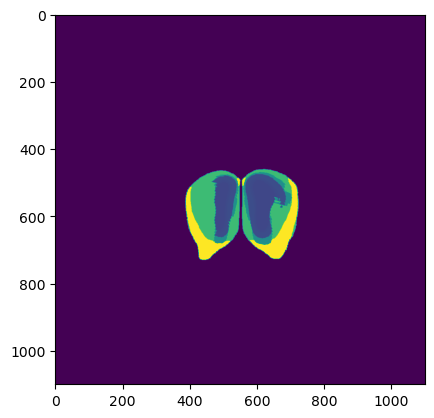

In [33]:
plt.imshow(annotation_array[71]);

Dict of dicts contains slice numbers, within each subdict one finds the regions in that slice and their respective voxel counts in 10 um resolution. The pickle file is then used to calculate densities by dividing cell counts by the volume

In [34]:
import pickle

view_directory = '/gpfs/bbp.cscs.ch/data/project/proj84/csaba/aibs_10x_mouse_wholebrain/results/nmi_scores/'
file = os.path.join( view_directory, 'template_with_regids.pickle')


# Save dict_of_dicts to a pickle file
with open(file, 'wb') as pickle_file:
    pickle.dump(dict_of_dicts, pickle_file)
